# ML Zoomcamp 2023 – Second Capstone Project

This notebook uses the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs). First run the `make_dataset.py` file to download and extract the raw images.

In [1]:
import os
import re
import subprocess
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    import skimage
    print('Module skimage is installed.')
except ImportError:
    print('Module skimage is not installed, installing it now with pip.')
    p1 = subprocess.run('python -m pip install scikit-image -q', shell=True,
                        check=True, capture_output=True, text=True)
    if p1.stderr:
          print(p1.stderr)
from skimage.io import imread
from skimage.transform import resize

Module skimage is installed.


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [4]:
images_dir = Path.cwd() / 'data/raw/Images'
annotation_dir = Path.cwd() / 'data/raw/Annotation'
processed_dir = Path.cwd() / 'data/processed'

## Data preparation

In [5]:
# folder names come from namimg in raw/Images and raw/Annotation folders
breed_dir_list = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                  'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                  'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                  'n02111129-Leonberg']

In [6]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
if not processed_dir.exists():
    Path.mkdir(processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed already exists.


In [7]:
t0 = time()
img_size = 299
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(processed_dir.glob('**/*.jpg')):
    for breed_dir in breed_dir_list:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(str(processed_dir) + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {str(processed_dir)} with cropped images already exists.')

Saving 299x299 image sizes.
Folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed with cropped images already exists.


### Removal of corrupted images

In [8]:
num_skipped = 0
for folder_name in breed_dir_list:
    folder_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(folder_name))
    folder_name = re.sub(r'-', r'_', folder_name.lower())
    breed_dir = processed_dir / folder_name
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = breed_dir / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/maltese_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/afghan_hound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/scottish_deerhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/pomeranian
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/bernese_mountain_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/samoyed
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/irish_wolfhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/shih_tzu
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/great_pyrenees
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/leonberg
Deleted

## Pre-trained convolutional neural networks

In [9]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [10]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=(img_size, img_size))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 1s 839ms/step


[[('n02092002', 'Scottish_deerhound', 0.7939882),
  ('n02090721', 'Irish_wolfhound', 0.04308395),
  ('n02090622', 'borzoi', 0.005164045),
  ('n02091244', 'Ibizan_hound', 0.0030015495),
  ('n02100236', 'German_short-haired_pointer', 0.0029592111)]]

## Data generation

In [11]:
new_img_size = 150
image_size_tuple = (new_img_size, new_img_size)
batch_size = 32

In [12]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.3,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
    shuffle=True,
)

Found 2233 files belonging to 10 classes.
Using 1564 files for training.
Using 669 files for validation.


In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 2)
val_ds = val_ds.skip((1*val_batches) // 2)

### Data visualization

In [14]:
names = train_ds.class_names

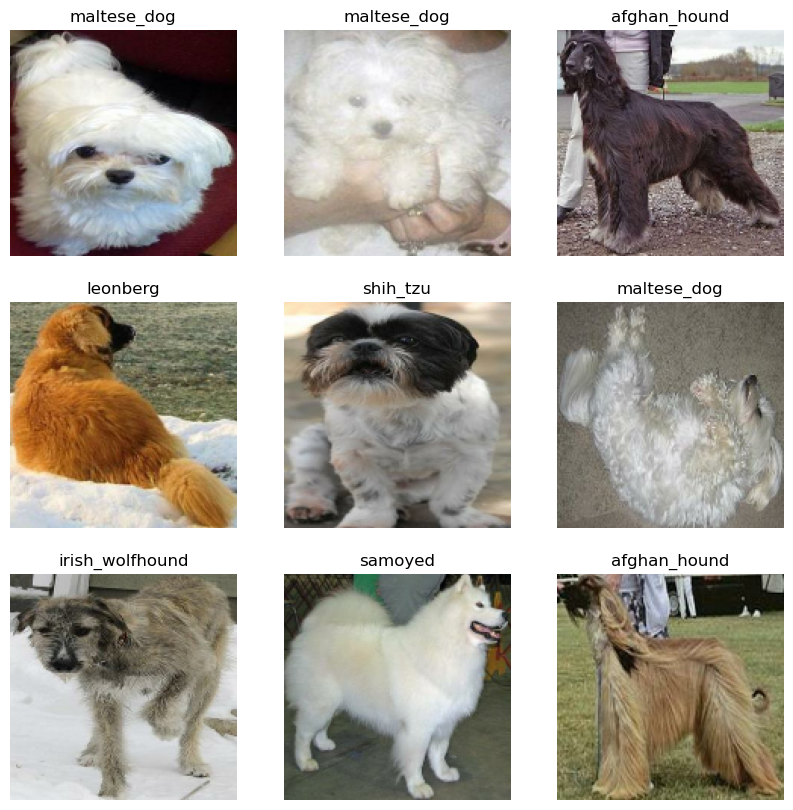

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Transfer learning

Using a small image size to decrease training time.

In [16]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [17]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [18]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
49/49 [==============================] - 41s 785ms/step - loss: 33.6998 - accuracy: 0.2423 - val_loss: 19.0295 - val_accuracy: 0.3524
Epoch 2/10
49/49 [==============================] - 38s 774ms/step - loss: 11.9977 - accuracy: 0.3798 - val_loss: 15.9605 - val_accuracy: 0.3066
Epoch 3/10
49/49 [==============================] - 38s 773ms/step - loss: 11.4906 - accuracy: 0.4124 - val_loss: 14.4440 - val_accuracy: 0.3181
Epoch 4/10
49/49 [==============================] - 38s 771ms/step - loss: 9.6078 - accuracy: 0.4648 - val_loss: 13.3530 - val_accuracy: 0.3352
Epoch 5/10
49/49 [==============================] - 38s 780ms/step - loss: 9.1148 - accuracy: 0.4770 - val_loss: 22.2316 - val_accuracy: 0.3610
Epoch 6/10
49/49 [==============================] - 38s 772ms/step - loss: 10.7561 - accuracy: 0.5026 - val_loss: 18.4324 - val_accuracy: 0.3668
Epoch 7/10
49/49 [==============================] - 38s 773ms/step - loss: 9.2347 - accuracy: 0.5269 - val_loss: 15.2143 - val_accur

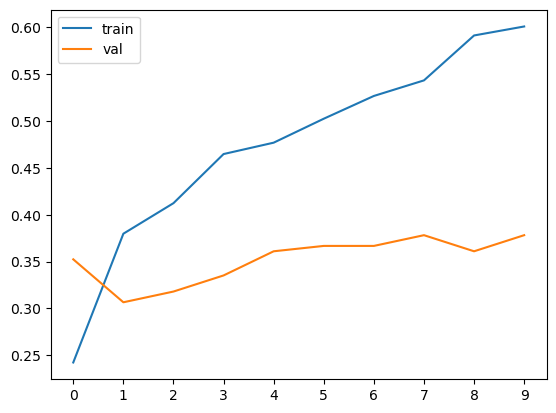

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Data augmentation

In [20]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

In [21]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

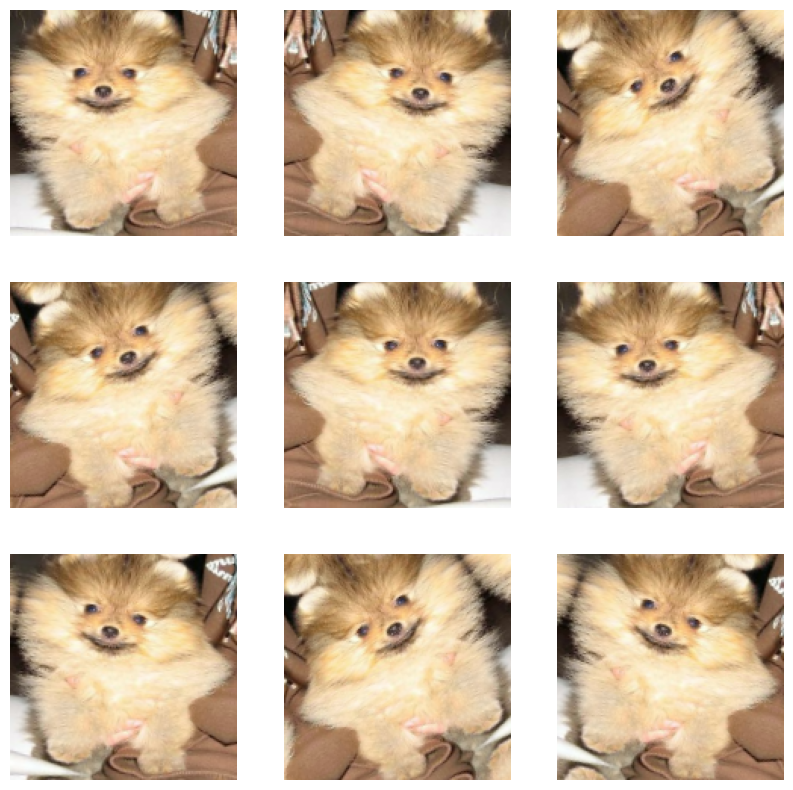

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [23]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
augmented_inputs = data_augmentation(inputs)
scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
base = base_model(scaled_inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [24]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [25]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
49/49 [==============================] - 42s 813ms/step - loss: 0.9187 - accuracy: 0.8191 - val_loss: 0.4325 - val_accuracy: 0.9140
Epoch 2/10
49/49 [==============================] - 39s 796ms/step - loss: 0.5714 - accuracy: 0.8836 - val_loss: 0.4537 - val_accuracy: 0.9255
Epoch 3/10
49/49 [==============================] - 39s 794ms/step - loss: 0.5224 - accuracy: 0.8926 - val_loss: 0.3782 - val_accuracy: 0.9370
Epoch 4/10
49/49 [==============================] - 39s 800ms/step - loss: 0.4644 - accuracy: 0.8977 - val_loss: 0.4627 - val_accuracy: 0.9226
Epoch 5/10
49/49 [==============================] - 39s 793ms/step - loss: 0.5022 - accuracy: 0.9054 - val_loss: 0.5914 - val_accuracy: 0.9169
Epoch 6/10
49/49 [==============================] - 39s 793ms/step - loss: 0.3745 - accuracy: 0.9265 - val_loss: 0.4063 - val_accuracy: 0.9284
Epoch 7/10
49/49 [==============================] - 39s 794ms/step - loss: 0.5839 - accuracy: 0.9041 - val_loss: 0.5772 - val_accuracy: 0.9140

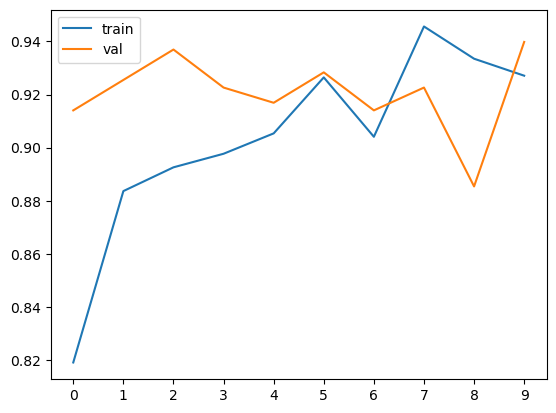

In [26]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Tuning the learning rate

In [27]:
def make_model(learning_rate=0.01):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [28]:
learning_rate_scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f'Learning rate: {lr}')
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    learning_rate_scores[lr] = history.history
    print()
    print('*****'*10)
    print()

Learning rate: 0.0001
Epoch 1/10
49/49 [==============================] - 43s 819ms/step - loss: 1.9643 - accuracy: 0.3427 - val_loss: 1.3253 - val_accuracy: 0.6189
Epoch 2/10
49/49 [==============================] - 39s 793ms/step - loss: 1.0794 - accuracy: 0.7142 - val_loss: 0.7357 - val_accuracy: 0.8625
Epoch 3/10
49/49 [==============================] - 39s 793ms/step - loss: 0.7107 - accuracy: 0.8286 - val_loss: 0.4924 - val_accuracy: 0.9112
Epoch 4/10
49/49 [==============================] - 39s 792ms/step - loss: 0.5465 - accuracy: 0.8638 - val_loss: 0.3815 - val_accuracy: 0.9198
Epoch 5/10
49/49 [==============================] - 39s 792ms/step - loss: 0.4716 - accuracy: 0.8683 - val_loss: 0.3209 - val_accuracy: 0.9198
Epoch 6/10
49/49 [==============================] - 39s 795ms/step - loss: 0.4183 - accuracy: 0.8811 - val_loss: 0.2839 - val_accuracy: 0.9226
Epoch 7/10
49/49 [==============================] - 39s 797ms/step - loss: 0.3833 - accuracy: 0.8919 - val_loss: 0.2605 

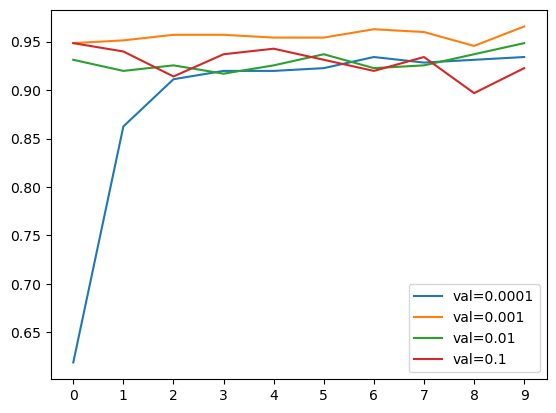

In [29]:
for lr, hist in learning_rate_scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.legend()

## Adjusting inner layers

In [30]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [31]:
best_learning_rate = 0.001
size_scores = {}
for size in [10, 100, 1000]:
    print(f'Inner layer size: {size}')
    model = make_model(learning_rate=best_learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    size_scores[size] = history.history
    print()
    print('*****'*10)
    print()

Inner layer size: 10
Epoch 1/10
49/49 [==============================] - 43s 818ms/step - loss: 1.0470 - accuracy: 0.6944 - val_loss: 0.2997 - val_accuracy: 0.9169
Epoch 2/10
49/49 [==============================] - 39s 793ms/step - loss: 0.4139 - accuracy: 0.8760 - val_loss: 0.2310 - val_accuracy: 0.9284
Epoch 3/10
49/49 [==============================] - 39s 794ms/step - loss: 0.3229 - accuracy: 0.8958 - val_loss: 0.2248 - val_accuracy: 0.9255
Epoch 4/10
49/49 [==============================] - 39s 800ms/step - loss: 0.2983 - accuracy: 0.9060 - val_loss: 0.1931 - val_accuracy: 0.9513
Epoch 5/10
49/49 [==============================] - 39s 794ms/step - loss: 0.2654 - accuracy: 0.9092 - val_loss: 0.1895 - val_accuracy: 0.9484
Epoch 6/10
49/49 [==============================] - 39s 792ms/step - loss: 0.2609 - accuracy: 0.9169 - val_loss: 0.2005 - val_accuracy: 0.9456
Epoch 7/10
49/49 [==============================] - 39s 798ms/step - loss: 0.2196 - accuracy: 0.9258 - val_loss: 0.2021 -

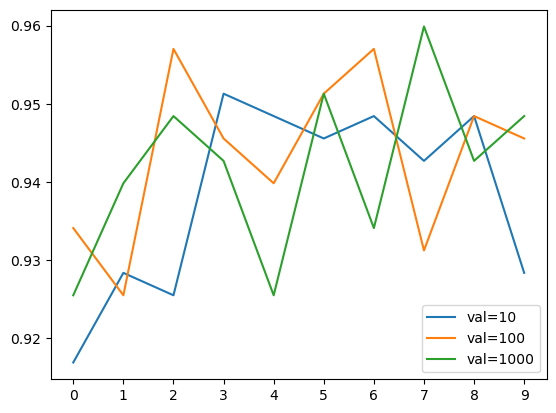

In [32]:
for size, hist in size_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
plt.legend()

## Adding dropout

In [33]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [35]:
best_learning_rate = 0.001
best_size = 1000
droprate_scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f'Dropout rate: {droprate}')
    model = make_model(learning_rate=best_learning_rate, size_inner=best_size, droprate=droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    droprate_scores[droprate] = history.history
    print()
    print('*****'*10)
    print()

Dropout rate: 0.0
Epoch 1/30
49/49 [==============================] - 44s 828ms/step - loss: 0.6404 - accuracy: 0.8165 - val_loss: 0.2610 - val_accuracy: 0.9140
Epoch 2/30
49/49 [==============================] - 40s 812ms/step - loss: 0.3088 - accuracy: 0.8951 - val_loss: 0.2199 - val_accuracy: 0.9255
Epoch 3/30
49/49 [==============================] - 40s 807ms/step - loss: 0.2711 - accuracy: 0.9047 - val_loss: 0.1826 - val_accuracy: 0.9284
Epoch 4/30
49/49 [==============================] - 39s 802ms/step - loss: 0.1984 - accuracy: 0.9271 - val_loss: 0.1877 - val_accuracy: 0.9427
Epoch 5/30
49/49 [==============================] - 40s 808ms/step - loss: 0.1940 - accuracy: 0.9335 - val_loss: 0.1510 - val_accuracy: 0.9542
Epoch 6/30
49/49 [==============================] - 39s 807ms/step - loss: 0.2016 - accuracy: 0.9329 - val_loss: 0.2285 - val_accuracy: 0.9198
Epoch 7/30
49/49 [==============================] - 40s 807ms/step - loss: 0.1994 - accuracy: 0.9309 - val_loss: 0.2827 - va

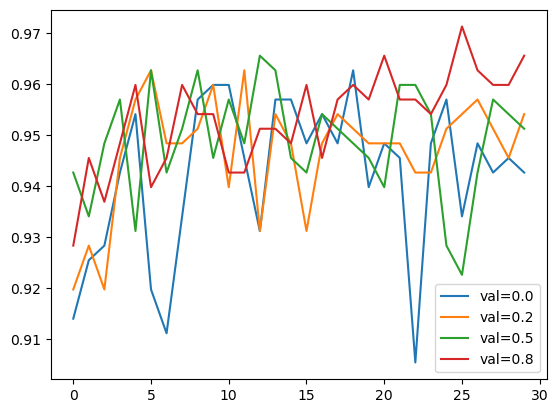

In [37]:
for droprate, hist in droprate_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
# plt.ylim(0.86, 0.95)
plt.legend(loc=4)

## Saving best model with checkpointing

In [46]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [47]:
learning_rate = 0.001
size = 1000
droprate = 0.8
model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)

In [48]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50
49/49 [==============================] - 43s 828ms/step - loss: 1.0455 - accuracy: 0.7366 - val_loss: 0.1974 - val_accuracy: 0.9456
Epoch 2/50
49/49 [==============================] - 39s 805ms/step - loss: 0.5764 - accuracy: 0.8395 - val_loss: 0.1812 - val_accuracy: 0.9456
Epoch 3/50
49/49 [==============================] - 40s 808ms/step - loss: 0.4545 - accuracy: 0.8651 - val_loss: 0.1623 - val_accuracy: 0.9484
Epoch 4/50
49/49 [==============================] - 39s 806ms/step - loss: 0.4428 - accuracy: 0.8542 - val_loss: 0.1587 - val_accuracy: 0.9427
Epoch 5/50
49/49 [==============================] - 40s 809ms/step - loss: 0.4553 - accuracy: 0.8587 - val_loss: 0.1585 - val_accuracy: 0.9570
Epoch 6/50
49/49 [==============================] - 39s 804ms/step - loss: 0.4162 - accuracy: 0.8625 - val_loss: 0.1611 - val_accuracy: 0.9570
Epoch 7/50
49/49 [==============================] - 39s 806ms/step - loss: 0.4070 - accuracy: 0.8792 - val_loss: 0.1561 - val_accuracy: 0.9513

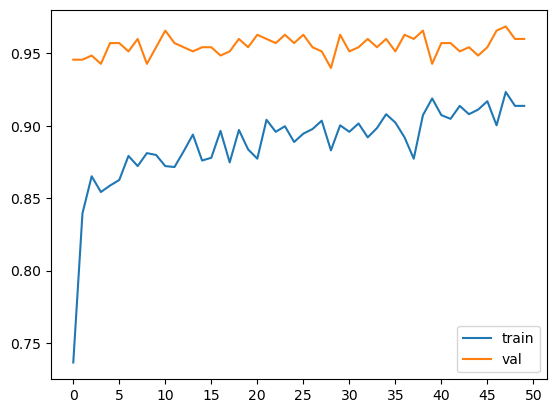

In [49]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.linspace(0, 50, 11))
plt.legend()

## Testing the model

In [50]:
best_model = keras.models.load_model('xception_v1_48_0.968.h5')

In [54]:
loss, test_acc = best_model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

10/10 [==============================] - 6s 627ms/step - loss: 0.2034 - accuracy: 0.9219
Test accuracy: 0.9219
